In [1]:
%matplotlib inline
import pickle
import datetime
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from functools import reduce
from sklearn import ensemble
from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import itertools

## Load the data

In [2]:
try:
    df = pickle.load(df, open( "data.pickle", "wb" ))
except:
    df = pd.read_csv('CrowdstormingDataJuly1st.csv', parse_dates = ['birthday'])
    pickle.dump(df, open( "data.pickle", "wb" ))

## Structure of the data

Every row corresponds to a (player, referee) pair.
The table can be seen as a join of tree tables:
* a table describing player attributes only,
* table describing referee attributes only ,
* table describing (player, referee) pair attributes only.

In other words every attribute is a function of
* `playerShort`
* or `refNum`
* or `(playerShort, refNum)` pair.

We will check now that the data meets this assumption because further code relies on it.

In [3]:
def functionAttrsFor(df, colname):
    """Find attributes whose value may be uniquely inferred from `colname` attribute value.
       Returns a boolean Series object with colnames as indices.
       If value for a given attribute is true then this attribute a function of `colname` attribute.
    """
    return df.groupby(colname).agg(lambda col: col.nunique(dropna=False) == 1).apply(all)

playerAttrs  = functionAttrsFor(df.drop('refNum', axis=1), 'playerShort')
refereeAttrs = functionAttrsFor(df.drop('playerShort', axis=1), 'refNum')
otherAttrs = ~(playerAttrs | refereeAttrs)

attributes = list(zip(
    ['playerShort', 'refNum', '(playerShort, refNum)'],
    map(lambda x: list(x[x].index), [playerAttrs, refereeAttrs, otherAttrs])
))

for x in attributes:
    template = "Following attributes are a function of {}:"
    print(template.format(x[0]))
    print('\n'.join(x[1]))
    print('')

Following attributes are a function of playerShort:
player
club
leagueCountry
birthday
height
weight
position
photoID
rater1
rater2

Following attributes are a function of refNum:
refCountry
Alpha_3
meanIAT
nIAT
seIAT
meanExp
nExp
seExp

Following attributes are a function of (playerShort, refNum):
games
victories
ties
defeats
goals
yellowCards
yellowReds
redCards



In [4]:
any(df.duplicated(['playerShort', 'refNum']))

False

These functional dependencies agree with the data description.
Moreover, `(playerShort, refNum)` pair is a primary key for this table.

# Cleaning

We first drop players that don't have a skin rating (which is caused by the absence of their photo).

In [5]:
template = "We drop {:.0f}% of observations because they don't have a photo."
percentage = 100 * df.photoID.isnull().sum() / len(df)
print(template.format(percentage))

df = df[df.photoID.notnull()]

if any(df['rater1'].isnull()) or any(df['rater2'].isnull()):
    print("Some players with a photo lack a skin rating.")
else:
    print("All other observations have non-null skin ratings.")

We drop 15% of observations because they don't have a photo.
All other observations have non-null skin ratings.


Let's check if there are more missing values in any column.

In [6]:
df.apply(pd.isnull, axis=0).sum()

playerShort         0
player              0
club                0
leagueCountry       0
birthday            0
height             46
weight            753
position         8461
games               0
victories           0
ties                0
defeats             0
goals               0
yellowCards         0
yellowReds          0
redCards            0
photoID             0
rater1              0
rater2              0
refNum              0
refCountry          0
Alpha_3             1
meanIAT           153
nIAT              153
seIAT             153
meanExp           153
nExp              153
seExp             153
dtype: int64

We see that there are a few missing values.
We can simply drop the players that don't have a height or weight 
and the referees without bias score (not many observations).
Since there are a lot of players without a position we create a category for them.

In [7]:
# Drop players without reported height.
df = df[df['height'].notnull()]
# Drop players without reported weight.
df = df[df['weight'].notnull()]
# Drop the referees without bias score data.
df = df[df['meanIAT'].notnull()]

# Create a noPosition category for players without a position.
df.loc[df['position'].isnull(), 'position'] = 'noPosition'

if df.notnull().values.all():
    print("All NA values have already been removed.")

All NA values have already been removed.


We also decided not to remove the referees who have less than 22 dyads as we aren't interested in the league only but racial bias in general

# Exercise 1
## Methodology
For this supervised learning problem of predicting whether a player is black or white we use Random Forest. We will use the skin-color rating as a binary label for classification with skinColor {0, 0.25} -> white and {0.5, 0.75, 1} -> black.
<br>
We use dyads to generate features for each player so as to have a single entry per player representing his characteristics.
<br>
We then fit our player characteristics into Random Forest using K-fold Cross Validation.
<br>
We kept some steps used to find good features and we also implemented the bonus which was to find good hyperparameters for Random Forest and checked feature importance but as some of this work is incremental we didn't keep all the steps in the notebook.

## Feature engineering
We built dummy features from categorical features such as position and country. We also found good features by trial and error and stopping when the accuracy was good.

### Feature generation:

In [8]:
def genFeatures(player):
    """Return player's features representing his characteristics given his player-referee pairs."""
    sample = player.iloc(0)[0] # used to get values constant for the player
    
    age = relativedelta(datetime.datetime.now(), sample['birthday']).years
    
    bmi = sample['weight'] / pow(sample['height'] / 100, 2)
    games = player['games'].sum()
    winRate = player['victories'].sum() / games
    tiesRate = player['ties'].sum() / games
    loseRate = player['defeats'].sum() / games
    yellowRedsRate = player['yellowReds'].sum() / games
    yellowRate = player['yellowCards'].sum() / games
    redRate = player['redCards'].sum() / games
    IAT = (player['meanExp'] * player['games']).sum() / games
    Exp = (player['meanIAT'] * player['games']).sum() / games
    IAT2 = player['meanExp'].mean()
    Exp2 = player['meanIAT'].mean()
    seIAT = math.sqrt((player['nIAT'] * pow(player['seIAT'], 2)).sum()) / (player['nIAT'].sum())
    seExp = math.sqrt((player['nExp'] * pow(player['seExp'],2)).sum()) / (player['nExp'].sum())

    yellowRateRacistIAT = (player['yellowCards'] * (player['meanIAT'] > 0.35)).sum() / (1e-3+(player['games'] * (player['meanIAT'] > 0.35)).sum())
    yellowRateNonRacistIAT = (player['yellowCards'] * (player['meanIAT'] < 0.35)).sum() / (1e-3+(player['games'] * (player['meanIAT'] < 0.35)).sum())
    racismIAT = yellowRateRacistIAT / (1e-3+yellowRateNonRacistIAT)
    yellowRateRacistExp = (player['yellowCards'] * (player['meanExp'] > 0.5)).sum() / (1e-3+(player['games'] * (player['meanExp'] > 0.5)).sum())
    yellowRateNonRacistExp = (player['yellowCards'] * (player['meanExp'] < 0.5)).sum() / (1e-3+(player['games'] * (player['meanExp'] < 0.5)).sum())
    racismExp = yellowRateRacistExp / (1e-3+yellowRateNonRacistExp)
    
    position = sample['position']
    goalRatio = player['goals'].sum() / games
    
    return pd.Series({
            'player': sample['player'],
            'age': age,
            'height': sample['height'],
            'weight': sample['weight'], 
            'bmi': bmi,
            'country': sample['leagueCountry'],
            'games': games,
            'winRate': winRate,
            'tiesRate': tiesRate,
            'loseRate': loseRate,
            'yellowRate': yellowRate,
            'yellowRedsRate': yellowRedsRate,
            'yellowOverRed': redRate/(yellowRate+1e-3),
            'redRate': redRate,
            'skinColor': (sample['rater1'] + sample['rater2'])/2, # we average the ratings
            'goalRatio': goalRatio,
            'IAT': IAT,
            'Exp': Exp,
            'IAT2': IAT2,
            'Exp2': Exp2,
            'seIAT': seIAT,
            'seExp': seExp,
            'racismIAT': racismIAT,
            'racismExp': racismExp,
            'position': position,
            })

players_tmp = df.groupby('playerShort').apply(genFeatures)

### Add dummy variables

In [12]:
position_dummy = pd.get_dummies(players_tmp['position'])
position_dummy_keys = position_dummy.keys()
country_dummy = pd.get_dummies(players_tmp['country'])
country_dummy_keys = country_dummy.keys()

players = pd.concat([players_tmp, position_dummy, country_dummy], axis = 1)
players.keys()

Index(['Exp', 'Exp2', 'IAT', 'IAT2', 'age', 'bmi', 'country', 'games',
       'goalRatio', 'height', 'loseRate', 'player', 'position', 'racismExp',
       'racismIAT', 'redRate', 'seExp', 'seIAT', 'skinColor', 'tiesRate',
       'weight', 'winRate', 'yellowOverRed', 'yellowRate', 'yellowRedsRate',
       'Attacking Midfielder', 'Center Back', 'Center Forward',
       'Center Midfielder', 'Defensive Midfielder', 'Goalkeeper',
       'Left Fullback', 'Left Midfielder', 'Left Winger', 'Right Fullback',
       'Right Midfielder', 'Right Winger', 'noPosition', 'England', 'France',
       'Germany', 'Spain'],
      dtype='object')

### Build the test and train sets:

In [13]:
# 2 classes, {0, 0.25}-> white (no racial bias) and {0.5, 0.75, 1} -> black (racial bias)
y = players['skinColor'] >= 0.5
features = list(itertools.chain([
    'games',
    'goalRatio',
    'age',
    'bmi',
    'height',
    'weight',
    'yellowRate',
    'yellowRedsRate',
    'redRate',
    'yellowOverRed', 
    'winRate',
    'loseRate',
    'tiesRate',
    'IAT',
    'Exp',
    'IAT2',
    'Exp2',
    'seIAT',
    'seExp',
    'racismIAT',
    'racismExp',
], position_dummy_keys, country_dummy_keys))
X = players[features]

# Standardize features
X_std = X.sub(X.mean(), axis=1).div(X.std(), axis=1)

# Generate the train - test split.
# We stratify in order to have the same black-white proportion in both the train and the test set.
X_w, X_val, y_w, y_val = train_test_split(X_std, y, test_size=0.25, random_state=0, stratify = y)
X_w = np.asanyarray(X_w)

## Model Training:

In [41]:
def scorer(estimator, X_test, y_test, X_train, y_train):
    """Calculate (test accuracy, test F1, training accuracy, training F1).
    F1 is calculated for black players.
    """
    pred = estimator.predict(X_test)
    A = metrics.accuracy_score(y_test, pred)
    F1 = metrics.f1_score(y_test, pred)
    
    pred_train = estimator.predict(X_train)
    A_train = metrics.accuracy_score(y_train, pred_train)
    F1_Train = metrics.f1_score(y_train, pred_train)
    return (A, F1, A_train, F1_Train)

def CVstep(classifier, X, y, train_index, test_index, scorer):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    estimator = classifier.fit(X_train, y_train)
    return scorer(estimator, X_test, y_test, X_train, y_train)

# Takes an iterable of classifiers and returns their cross-validation results for each split.
# It uses the same splits for each model so they can be directly compared.
def CV(classifiers, X, y, scorer, n_folds):
    kf = cross_validation.StratifiedKFold(y, n_folds=n_folds)
    return [[CVstep(classifier, X, y, train_index, test_index, scorer) for classifier in classifiers]
            for train_index, test_index in kf]

### Choose the function measuring the split quality: gini vs. entropy

We will test 'gini' vs. 'entropy' criterion by setting other parameters to some intuitively sensible values and looking which performs better.

In [43]:
# We use balanced class weights to not neglect black values and only predict white.
otherParams = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 20,
    'class_weight':'balanced'
}

rf1 = ensemble.RandomForestClassifier(criterion = 'gini', **otherParams)
rf2 = ensemble.RandomForestClassifier(criterion = 'entropy', **otherParams)

# Cross-validation (average over 5 different 10-fold splits to smooth the result)
scores = np.concatenate(np.asarray([CV([rf1, rf2], X_w, y_w, scorer, 10) for i in range(0, 5)]))

In [44]:
print(scores[:, 0, 0].mean()) # acc of first model
print(scores[:, 1, 0].mean()) # acc of second model

print(scores[:, 0, 1].mean()) # f1 of first model
print(scores[:, 1, 1].mean()) # f1 of second model

0.774825438215
0.777031725337
0.488019285055
0.479977858108


We don't see a real difference between the two so we stay with the default (gini) which is a little bit faster.

# Bonus:
## Check how n_estimator affects the learning curve
We plot train and cross-validation scores versus increasing values of n_estimators (grid_search in usual terms) with other parameters fixed.

In [79]:
otherParams = {
    'max_depth': None,
    'min_samples_split': 20,
    'criterion': 'gini',
    'class_weight':'balanced'
}
rfs = [ensemble.RandomForestClassifier(n_estimators=n * 5, **otherParams) for n in range(1, 20)]
# Cross-validation (average over 3 different 20-fold splits to smooth the result)
scores_n_estimator = np.concatenate(np.asarray([CV(rfs, X_w, y_w, scorer, 20) for i in range(0, 3)]))

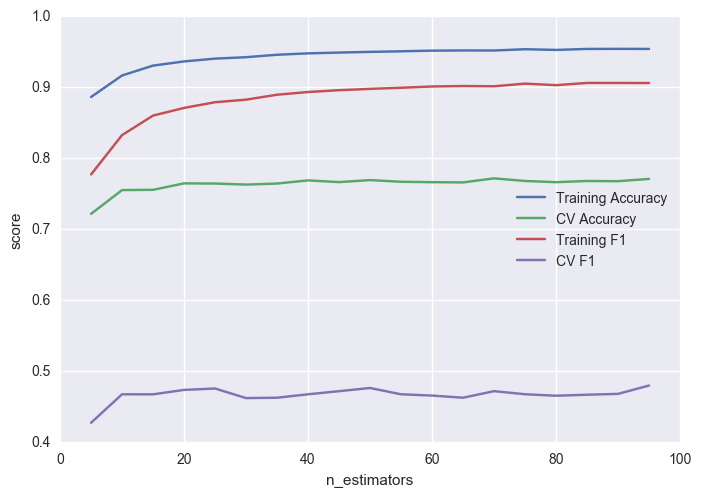

In [80]:
num_model = scores_n_estimator.shape[1]

cv_acc, test_F1, train_acc, train_F1 = scores_n_estimator.mean(axis=0).T

# Build Graph
axisRange = np.linspace(5, (num_model) * 5, num_model)

fig, ax = plt.subplots()

ax.plot(axisRange, train_acc, label='Training Accuracy')
ax.plot(axisRange, cv_acc, label='CV Accuracy')
ax.plot(axisRange, train_F1, label='Training F1')
ax.plot(axisRange, test_F1, label='CV F1')

# Now add the legend with some customizations.
legend = ax.legend(loc='center right', shadow=True)

plt.xlabel('n_estimators')
plt.ylabel('score')

 We will use n_estimator = 20 as it seems big enough and increasing it will mostly only increase computing time.
 It's worth noting that generally more trees is always better but it doesn't change much past some treshold.

## Check how min_samples_leaf affects the learning curve:
We plot train and cross-validation scores versus increasing values of min_samples_leaf.

In [102]:
otherParams = {
    'n_estimators': 20,
    'max_depth': 10,
    'criterion': 'gini',
    'class_weight':'balanced'
}
rfs = [ensemble.RandomForestClassifier(min_samples_leaf=n * 6, **otherParams) for n in range(1, 50)]
# Cross-validation (average over 3 different 20-fold splits to smooth the result)
scores_min_samples_leaf = np.concatenate(np.asarray([CV(rfs, X_w, y_w, scorer, 20) for i in range(0, 3)]))

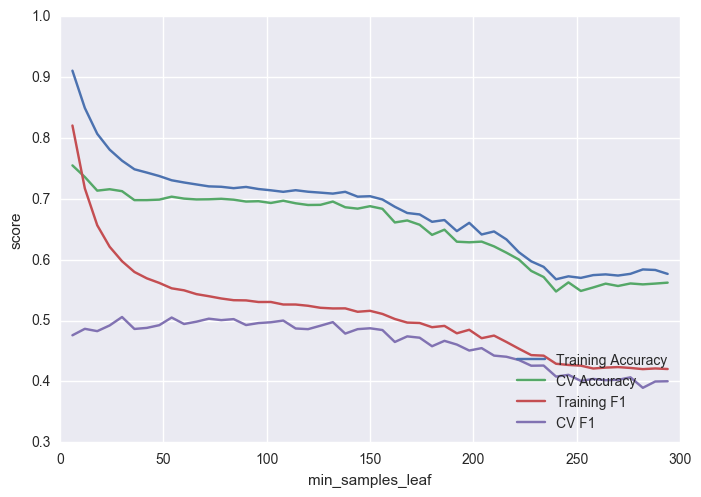

In [103]:
num_model = scores_min_samples_leaf.shape[1]

cv_acc, test_F1, train_acc, train_F1 = scores_min_samples_leaf.mean(axis=0).T
    
# Build Graph
axisRange = np.linspace(6, (num_model)*6, num_model)

fig, ax = plt.subplots()

ax.plot(axisRange, train_acc, label='Training Accuracy')
ax.plot(axisRange, cv_acc, label='CV Accuracy')
ax.plot(axisRange, train_F1, label='Training F1')
ax.plot(axisRange, test_F1, label='CV F1')

# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=True)

plt.xlabel('min_samples_leaf')
plt.ylabel('score')

We can see that as we increase the min_samples_leaf variable we underfit since Training scores go down. Obviously when min_sample_split is very small the model is overfitting. There is a tradeoff here. For example 100 the Test scores are close to Training scores. 

# Feature importance discussion

We'll plot our current feature weights in a bar graph and try to find a set of features that overfits as asked.
Given the above plots we use n_estimators = 20 and min_samples_leaf = 1.

<Container object of 38 artists>

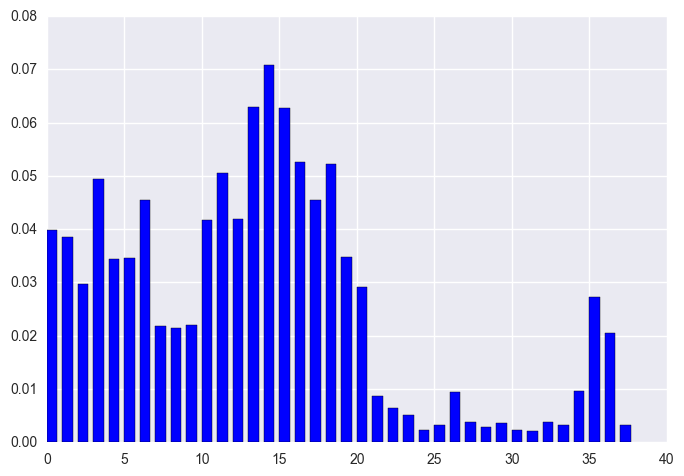

In [154]:
rf = ensemble.RandomForestClassifier(
    n_estimators = 20,
    max_depth = None,
    min_samples_leaf = 1,
    criterion = 'gini',
    class_weight = 'balanced')
rf.fit(X_w, y_w)

y = rf.feature_importances_
N = len(y)
x = range(N)
width = 1 / 1.5
plt.bar(x, y, width, color="blue")

In [160]:
print(list(X.columns[y > 0.06]))

['IAT', 'Exp', 'IAT2']


The most important features are 'IAT', 'Exp','IAT2'. It seems the racism bias score for the referees present on a player's match is important to figure out the skin color. <br>
Also, with this graph we could argue on what feature to remove.
Dummies were not very useful.

# Final model

In [163]:
rf = ensemble.RandomForestClassifier(
    n_estimators = 20,
    max_depth = None,
    min_samples_leaf = 1,
    criterion = 'gini',
    class_weight = 'balanced')

rf.fit(X_w, y_w)
pred = rf.predict(X_val)
A = metrics.accuracy_score(y_val, pred)
print('Acc = ' + str(A))
F1 = metrics.f1_score(y_val, pred)
print('F1 = ' + str(F1))

print(metrics.classification_report(y_val, pred))

Acc = 0.789743589744
F1 = 0.378787878788
             precision    recall  f1-score   support

      False       0.80      0.96      0.87       296
       True       0.66      0.27      0.38        94

avg / total       0.77      0.79      0.75       390



The accuracy is > 78%. We get a precision of 80% for whites and 66% for blacks. Given that we can predict both quite well, we see that there is some racial difference. Our generated features regarding racism did have some impact which allows us to imply that there is some racial bias.

We could try many things to improve it but it's already pretty good for this HW.

We ran this without the dummies featureas well and we had a slightly better precision, most likely because position dummies are useless as seen in the feature importance graph and adding an useless feature makes some trees less good because each tree at any level chooses only from sqrt(#feature) here.

# Exercise 2

## Methodology
To find clusters we use the K-means method. Since in this exercise we have to find clusters that have a good silouhette score and also separate the clusters well between black and white people, we don't use the skin-color to do the clustering but we use it after running K-means to verify how good our clusters is.
In the end we calculate several metrics and the goal is to find a good compromise between silouhette and F1 score.
To achieve this, we do automatic feature ablation. We check which feature, if removed from all the features gives us a new better F1 or silhouette score, and then we repeat this process. We can then check what subset of all our features gives the best tradeoff between well seperating white and black player, and having a nice silhouette.

## Difficulties and discussion
Why we need to use F1...
What could be improved...
Implication of finding a good cluster on racial bias...


In [21]:
def get_clustering_scores (X, y, verbose = False):
#     kmeans = KMeans(n_clusters=2, random_state=42, max_iter=500, init='k-means++').fit(X)
    kmeans = KMeans(n_clusters=2, random_state=42, max_iter=100, init='k-means++').fit(X)
    predictions = kmeans.predict(X)
    
    # check if we should invert the class labels (if the inverted setting gives a higher accuracy):
#     if metrics.accuracy_score(y, predictions) < metrics.accuracy_score(y, 1 - predictions):
    if len(predictions[predictions == 1]) > len(predictions[predictions == 0]):
        # invert labels because we are predicting 
        predictions = 1 - predictions
    A =  metrics.accuracy_score(y, predictions)
    F1 =  metrics.f1_score(y, predictions)
    s_score = silhouette_score(X, predictions)

    if verbose:
        print(pd.Series(predictions).value_counts())
        print(y.value_counts())

        print(metrics.f1_score(y, predictions))
        print(metrics.classification_report(y, predictions))

    return (s_score, A, F1)
    
def generate_X_std (players, features):
    X = players[features]
    return X.sub(X.mean(), axis=1).div(X.std(), axis = 1)


In [22]:
y = players['skinColor'] >= 0.5 # 2 classes, {0, 0.25}-> white (no racial bias) and {0.5, 0.75, 1} -> black (racial bias)
all_features = list(itertools.chain([
    'games',
    'goalRatio',
    'age',
    'bmi',
    'height',
    'weight',
    'yellowRate',
    'yellowRedsRate',
    'redRate',
    'yellowOverRed', 
    'winRate',
    'loseRate',
    'tiesRate',
    'IAT',
    'Exp',
    'IAT2',
    'Exp2',
    'seIAT',
    'seExp',
    'racismIAT',
    'racismExp',
], position_dummy_keys, country_dummy_keys))

In [23]:
X_std = generate_X_std(players, all_features)
get_clustering_scores(X_std, y, verbose = True)

0    1114
1     450
dtype: int64
False    1186
True      378
Name: skinColor, dtype: int64
0.159420289855
             precision    recall  f1-score   support

      False       0.72      0.68      0.70      1186
       True       0.15      0.17      0.16       378

avg / total       0.58      0.55      0.57      1564



(0.1509102216737217, 0.55498721227621484, 0.15942028985507248)

## Test

In [24]:
y = players['skinColor'] >= 0.5 # 2 classes, {0, 0.25}-> white (no racial bias) and {0.5, 0.75, 1} -> black (racial bias)

features = [
#     'winRate',
#     'IAT2'
    'France',
]
get_clustering_scores(generate_X_std(players, features), y, verbose = True)

0    1286
1     278
dtype: int64
False    1186
True      378
Name: skinColor, dtype: int64
0.393292682927
             precision    recall  f1-score   support

      False       0.81      0.87      0.84      1186
       True       0.46      0.34      0.39       378

avg / total       0.72      0.75      0.73      1564



(1.0, 0.74552429667519182, 0.39329268292682928)

In [25]:
features = [
#     'winRate',
#     'IAT2'
    'France',
    'racismIAT'
]
get_clustering_scores(generate_X_std(players, features), y, verbose = True)

0    1287
1     277
dtype: int64
False    1186
True      378
Name: skinColor, dtype: int64
0.393893129771
             precision    recall  f1-score   support

      False       0.81      0.88      0.84      1186
       True       0.47      0.34      0.39       378

avg / total       0.72      0.75      0.73      1564



(0.82386086107230228, 0.74616368286445012, 0.39389312977099239)

In [26]:
# feature ablation
features = list(all_features)

scores = get_clustering_scores(generate_X_std(players, all_features), y)
print('all features: silhouette score ' + str(scores[0]) + ' accuracy: ' + str(scores[1]) + ' F1: ' + str(scores[2]))

# for feature in features:
#     features_s = list(features)
#     features_s.remove(feature)
#     scores = get_clustering_scores(generate_X_std(players, features_s), y)
#     print(feature + str(scores[0]))

def score_wo_feature(features, feature):
    features_s = list(features)
    features_s.remove(feature)
    scores = get_clustering_scores(generate_X_std(players, features_s), y)
    return(feature, scores)

for i in range(0, len(all_features)-1):
    res = [score_wo_feature(features, feature) for feature in features]
    feat_to_remove = max(res, key = lambda x: x[1][2]) # max wrt f1 score
    print('remove: ' + feat_to_remove[0] + ', new silhouette score: ' + str(feat_to_remove[1][0]) + ' accuracy: ' + str(feat_to_remove[1][1]) + ' F1: ' + str(feat_to_remove[1][2]))
    features.remove(feat_to_remove[0])

all features: silhouette score 0.150910221674 accuracy: 0.554987212276 F1: 0.159420289855
remove: racismIAT, new silhouette score: 0.137312372535 accuracy: 0.550511508951 F1: 0.173913043478
remove: Defensive Midfielder, new silhouette score: 0.142298329126 accuracy: 0.551150895141 F1: 0.176056338028
remove: age, new silhouette score: 0.147129465775 accuracy: 0.551150895141 F1: 0.176056338028
remove: Left Midfielder, new silhouette score: 0.150732995256 accuracy: 0.550511508951 F1: 0.177777777778
remove: tiesRate, new silhouette score: 0.153620242961 accuracy: 0.552429667519 F1: 0.178403755869
remove: bmi, new silhouette score: 0.159738328278 accuracy: 0.552429667519 F1: 0.178403755869
remove: yellowOverRed, new silhouette score: 0.160987600699 accuracy: 0.552429667519 F1: 0.178403755869
remove: Attacking Midfielder, new silhouette score: 0.167234969829 accuracy: 0.552429667519 F1: 0.178403755869
remove: Center Forward, new silhouette score: 0.173977864128 accuracy: 0.552429667519 F1: 0

## Feature addition

In [27]:
features = list()
unused_features = list(all_features)


def score_w_feature(features, feature):
    features_s = list(features)
    features_s.append(feature)
    scores = get_clustering_scores(generate_X_std(players, features_s), y)
    return(feature, scores)

for i in range(0, len(all_features)-1):
    res = [score_w_feature(features, feature) for feature in unused_features]
    feat_to_add = max(res, key = lambda x: x[1][2]) # max wrt f1 score
    print('add: ' + feat_to_add[0] + ', new silhouette score: ' + str(feat_to_add[1][0]) + ' accuracy: ' + str(feat_to_add[1][1]) + ' F1: ' + str(feat_to_add[1][2]))
    features.append(feat_to_add[0])
    unused_features.remove(feat_to_add[0])

add: France, new silhouette score: 1.0 accuracy: 0.745524296675 F1: 0.393292682927
add: racismIAT, new silhouette score: 0.823860861072 accuracy: 0.746163682864 F1: 0.393893129771
add: goalRatio, new silhouette score: 0.552761746743 accuracy: 0.746163682864 F1: 0.393893129771
add: age, new silhouette score: 0.403589850906 accuracy: 0.746163682864 F1: 0.393893129771
add: bmi, new silhouette score: 0.32583544157 accuracy: 0.746163682864 F1: 0.393893129771
add: height, new silhouette score: 0.269312876165 accuracy: 0.746163682864 F1: 0.393893129771
add: yellowRate, new silhouette score: 0.232874800812 accuracy: 0.746163682864 F1: 0.393893129771
add: tiesRate, new silhouette score: 0.234610709614 accuracy: 0.745524296675 F1: 0.395136778116
add: winRate, new silhouette score: 0.214994666046 accuracy: 0.745524296675 F1: 0.395136778116
add: seIAT, new silhouette score: 0.230697925472 accuracy: 0.746803069054 F1: 0.4
add: redRate, new silhouette score: 0.227892832083 accuracy: 0.746803069054 F